In [ ]:
!pip install  easyocr  git+https://github.com/JaidedAI/EasyOCR.git spacy gliner

  Cloning https://github.com/JaidedAI/EasyOCR.git to /tmp/pip-req-build-lc5_v2sr
  Running command git clone --filter=blob:none --quiet https://github.com/JaidedAI/EasyOCR.git /tmp/pip-req-build-lc5_v2sr
  Resolved https://github.com/JaidedAI/EasyOCR.git to commit c999505ef6b43be1c4ee36aa04ad979175178352
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 271.3/271.3 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 43.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 31.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux

In [ ]:
!pip install https://huggingface.co/spacy/en_core_web_sm/resolve/main/en_core_web_sm-any-py3-none-any.whl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 47.9 MB/s eta 0:00:00


In [ ]:
!pip install python-bidi==0.4.2

  Attempting uninstall: python-bidi
    Found existing installation: python-bidi 0.5.0
    Uninstalling python-bidi-0.5.0:
      Successfully uninstalled python-bidi-0.5.0


In [52]:
import spacy
import torch
import easyocr
import cv2
import re
import json
from google.colab.patches import cv2_imshow
from transformers import pipeline

In [ ]:
!pip install gliner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.6 MB/s eta 0:00:00


In [53]:
from gliner import GLiNER
model = GLiNER.from_pretrained("urchade/gliner_multi_pii-v1")

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:562: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [54]:
reader = easyocr.Reader(['en'])

In [55]:
def string_tokenizer(text):
    final_word_list = []
    words_list = text.replace(" ", "\n").split("\n")

    for element in words_list:
        if len(element) >= 2:
            final_word_list.append(element)

    return final_word_list

def similarity(a, b): return difflib.SequenceMatcher(None, a, b).ratio() * 100

def get_regexes():
    rules = {
        "PAN Number": {
            "regex": r"[A-Z]{5}[0-9]{4}[A-Z]{1}"
        },
        "Passport Number": {
            "regex": r"^(?!^0+$)[a-zA-Z0-9]{3,20}$"
        }
    }
    return rules

def compile_patterns(patterns):
    if isinstance(patterns, list):
        return [re.compile(pattern) for pattern in patterns]
    else:
        return [re.compile(patterns)]

def custom_pii(text, rules):
    results = []
    all_regexes = {key: re.compile(rule["regex"]) for key, rule in rules.items() if rule["regex"]}

    for key, pattern in all_regexes.items():
        matches = pattern.findall(text)
        if matches:
            results.append({'identifier_class': key, 'result': list(set(matches))})

    return results

def search_pii(text, rules):
    identifiers = custom_pii(text, rules)
    result = {
        "custom PII": identifiers
    }
    return result


In [56]:
import re
import spacy
import cv2
import json

# Function to identify PII using SpaCy and regex
def identify_pii(text, labels):
    # Load SpaCy’s NLP model for named entity recognition
    nlp = spacy.load('en_core_web_sm')

    # Process the input text
    doc = nlp(text)

    # Define PII categories and their labels
    pii_labels = {
        'SSN': 'social security number',
        'PHONE_NUMBER': 'phone number',
        'PAN Number': 'PAN number',
        "Passport Number": 'Passport number'
    }

    # Initialize the redacted text
    redacted_text = text

    # Extract entities from SpaCy
    pii_entities_spacy = [(ent.text, ent.label_) for ent in doc.ents if ent.label_ in pii_labels.keys()]

    # Placeholder for the model's entity prediction
    entities = model.predict_entities(text, labels)
    pii_entities_gliner = [(entity["text"], entity["label"]) for entity in entities]

    #Custom regex entities
    regex_result = search_pii(text, get_regexes())
    pii_entities_regex = []
    # Extract and map regex PII entities
    for item in regex_result['custom PII']:

        identifier_class = item['identifier_class']
        if identifier_class in pii_labels:
            for result in item['result']:
                pii_entities_regex.append((result, pii_labels[identifier_class]))

    # Combine entities from both SpaCy and the model
    pii_entities = set(pii_entities_spacy + pii_entities_gliner + pii_entities_regex)

    return pii_entities

# Function to draw black rectangles over PII
# def draw_black_rectangles(image, detections, labels):
#     font = cv2.FONT_HERSHEY_SIMPLEX
#     font_scale = 0.5  # Adjust as needed for your image
#     thickness = 1  # Adjust as needed for your image

#     for detection in detections:
#         coordinates, text, confidence = detection
#         # Convert coordinates to integer tuples
#         top_left = (int(coordinates[0][0]), int(coordinates[0][1]))
#         bottom_right = (int(coordinates[2][0]), int(coordinates[2][1]))

#         # Identify PII in the text
#         pii_entities = identify_pii(text, labels)

#         # If PII is found, draw a black rectangle over the entire bounding box
#         if pii_entities:
#             cv2.rectangle(image, top_left, bottom_right, (0, 0, 0), thickness=-1)



In [57]:
def draw_black_rectangles(image, detections, labels):
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.5  # Adjust as needed for your image
    thickness = 1  # Adjust as needed for your image

    tolerance = 0.05  # 10% tolerance

    for detection in detections:
        coordinates, text, confidence = detection
        # Convert coordinates to integer tuples
        top_left = (int(coordinates[0][0]), int(coordinates[0][1]))
        bottom_right = (int(coordinates[2][0]), int(coordinates[2][1]))

        # Identify PII in the text
        pii_entities = identify_pii(text, labels)

        # If PII is found, draw rectangles with tolerance
        if pii_entities:
            for entity, entity_type in pii_entities:
                # Here we assume that identify_pii function provides proportions of PII text
                # In practice, you will need to implement the logic to map entity positions
                # to bounding box proportions. This is a simplified example:

                entity_start = text.find(entity)
                entity_end = entity_start + len(entity)

                # Calculate proportions
                entity_start_fraction = entity_start / len(text)
                entity_end_fraction = entity_end / len(text)

                # Map fractions to bounding box coordinates
                entity_start_x = int(top_left[0] + (bottom_right[0] - top_left[0]) * entity_start_fraction)
                entity_end_x = int(top_left[0] + (bottom_right[0] - top_left[0]) * entity_end_fraction)

                # Apply tolerance
                entity_start_x = max(top_left[0], int(entity_start_x - (bottom_right[0] - top_left[0]) * tolerance))
                entity_end_x = min(bottom_right[0], int(entity_end_x + (bottom_right[0] - top_left[0]) * tolerance))

                # For simplicity, assume uniform height for each entity
                entity_top_left_y = top_left[1]
                entity_bottom_right_y = bottom_right[1]

                # Draw the rectangle for PII with tolerance
                cv2.rectangle(image, (entity_start_x, entity_top_left_y), (entity_end_x, entity_bottom_right_y), (0, 0, 0), thickness=-1)


In [58]:
import numpy as np

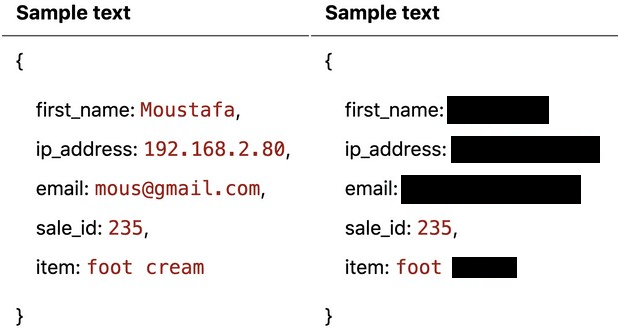

In [ ]:
# Load the image
labels = ["name", "ip_address", "email", "phone number"]
path = r'pii.jpg'
result = reader.readtext(path, width_ths=0.5)
image_path = path  # Replace with your image path
original_image = cv2.imread(image_path)

# Draw rectangles on the image
processed_image = original_image.copy()
draw_black_rectangles(processed_image, result, labels)
combined_image = np.hstack((original_image, processed_image))
# Save the modified image
# output_path = 'pii_blacked_out.jpg'
# cv2.imwrite(output_path, image)

# Display the modified image (optional)
cv2_imshow(combined_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


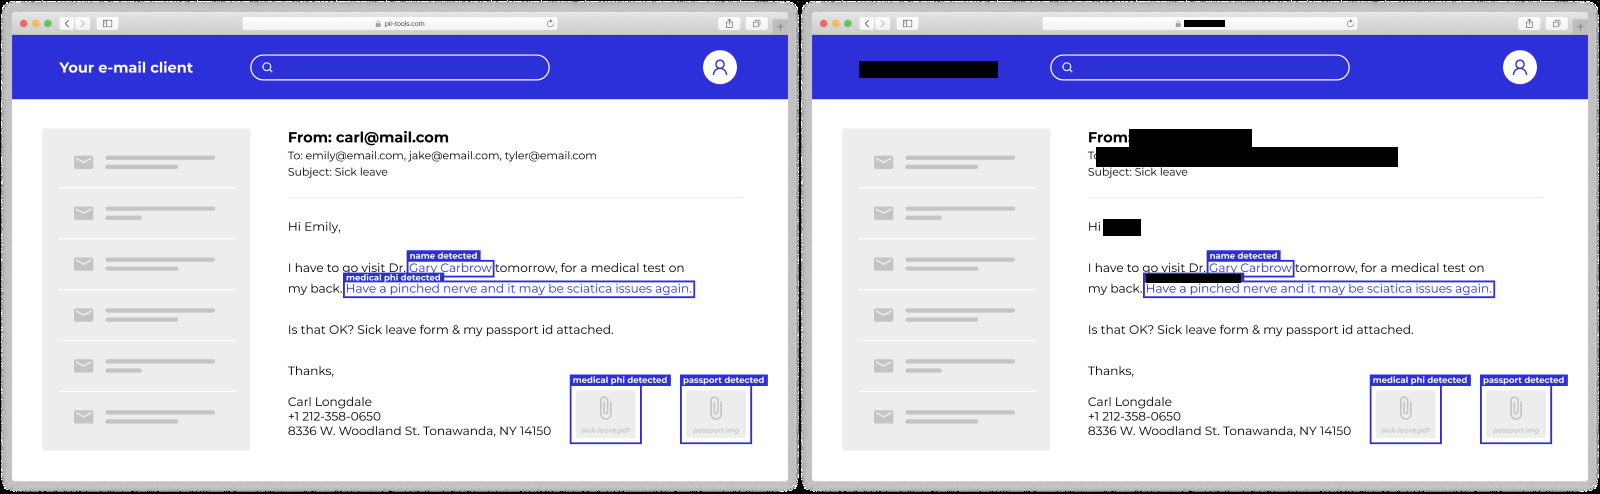

In [ ]:
# Load the image
labels = ["ip_address",  "personally identifiable information", "social security number", "full address",  "character", "email", "phone number"]
image_path = 'pii2.png'  # Replace with your image path
result = reader.readtext(image_path, width_ths=0.5)
original_image = cv2.imread(image_path)

# Draw rectangles on the image
processed_image = original_image.copy()
draw_black_rectangles(processed_image, result, labels)
combined_image = np.hstack((original_image, processed_image))
# Save the modified image
# output_path = 'pii_blacked_out.jpg'
# cv2.imwrite(output_path, image)

# Display the modified image (optional)
cv2_imshow(combined_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


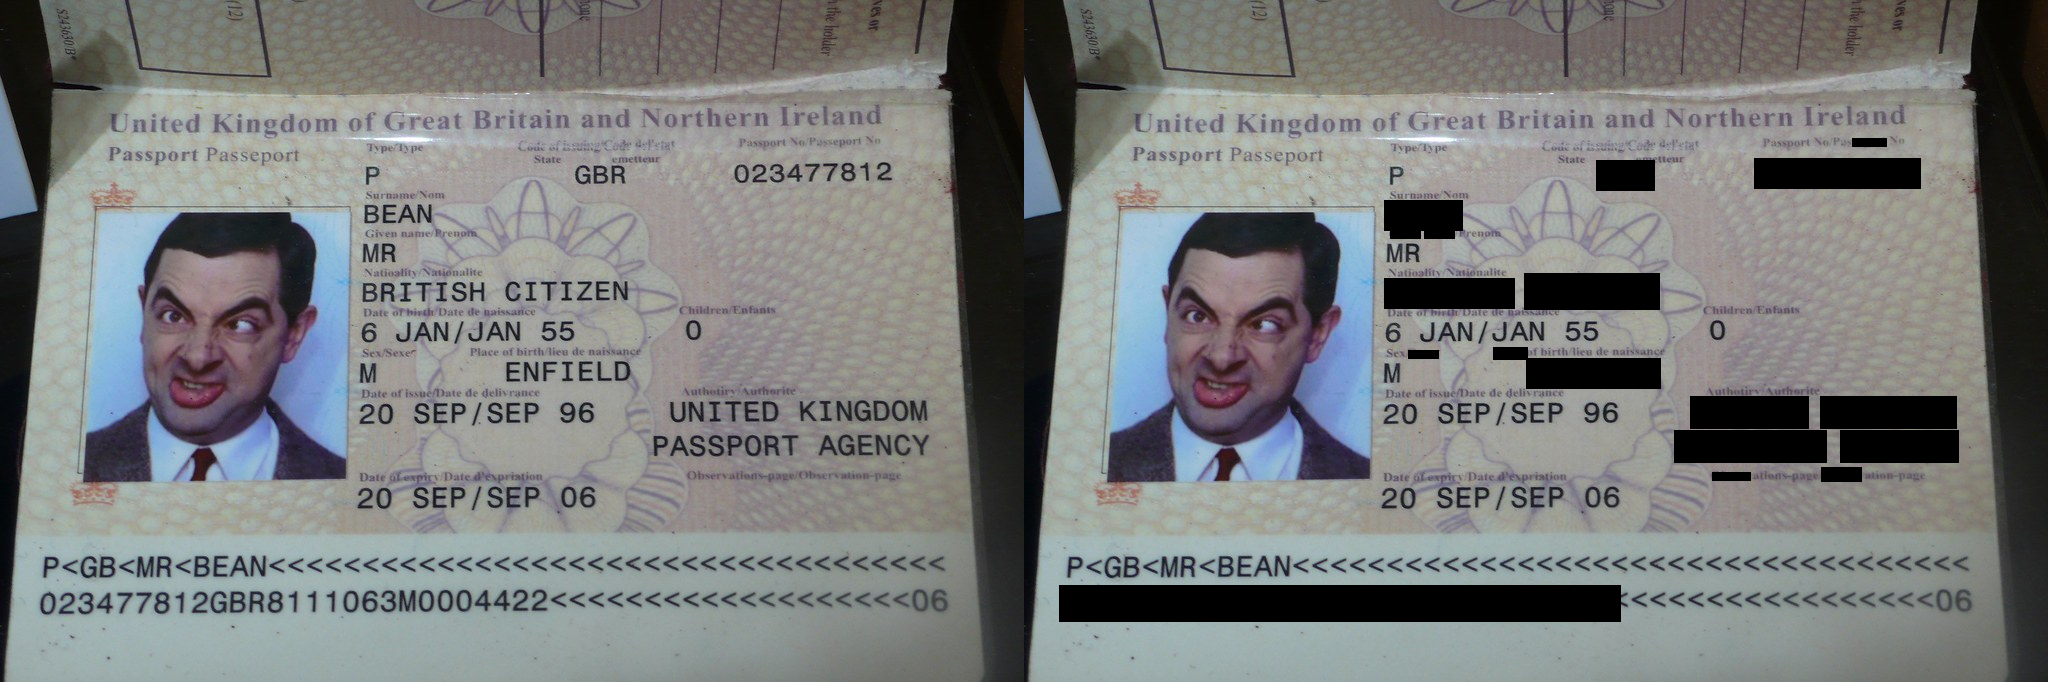

In [ ]:
# Load the image
labels = ["passport number", "personally identifiable information", "social security number", "driver licence", "full address",  "character"]
image_path = '/content/dummy-passport-britain.jpg'  # Replace with your image path
result = reader.readtext(image_path, width_ths=0.5)
original_image = cv2.imread(image_path)

# Draw rectangles on the image
processed_image = original_image.copy()
draw_black_rectangles(processed_image, result, labels)
combined_image = np.hstack((original_image, processed_image))
# Save the modified image
# output_path = 'pii_blacked_out.jpg'
# cv2.imwrite(output_path, image)

# Display the modified image (optional)
cv2_imshow(combined_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [92]:
pip install pytesseract PyMuPDF

In [86]:
!apt-get install poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.4).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [109]:
!pip install fpdf

  Preparing metadata (setup.py) ... done
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40702 sha256=3a09212cb7007778b4d91e7cdfc8d4a20524af906ba6bb0e3c930913074d7e7a
  Stored in directory: /root/.cache/pip/wheels/f9/95/ba/f418094659025eb9611f17cbcaf2334236bf39a0c3453ea455
Successfully built fpdf


In [110]:
from fpdf import FPDF

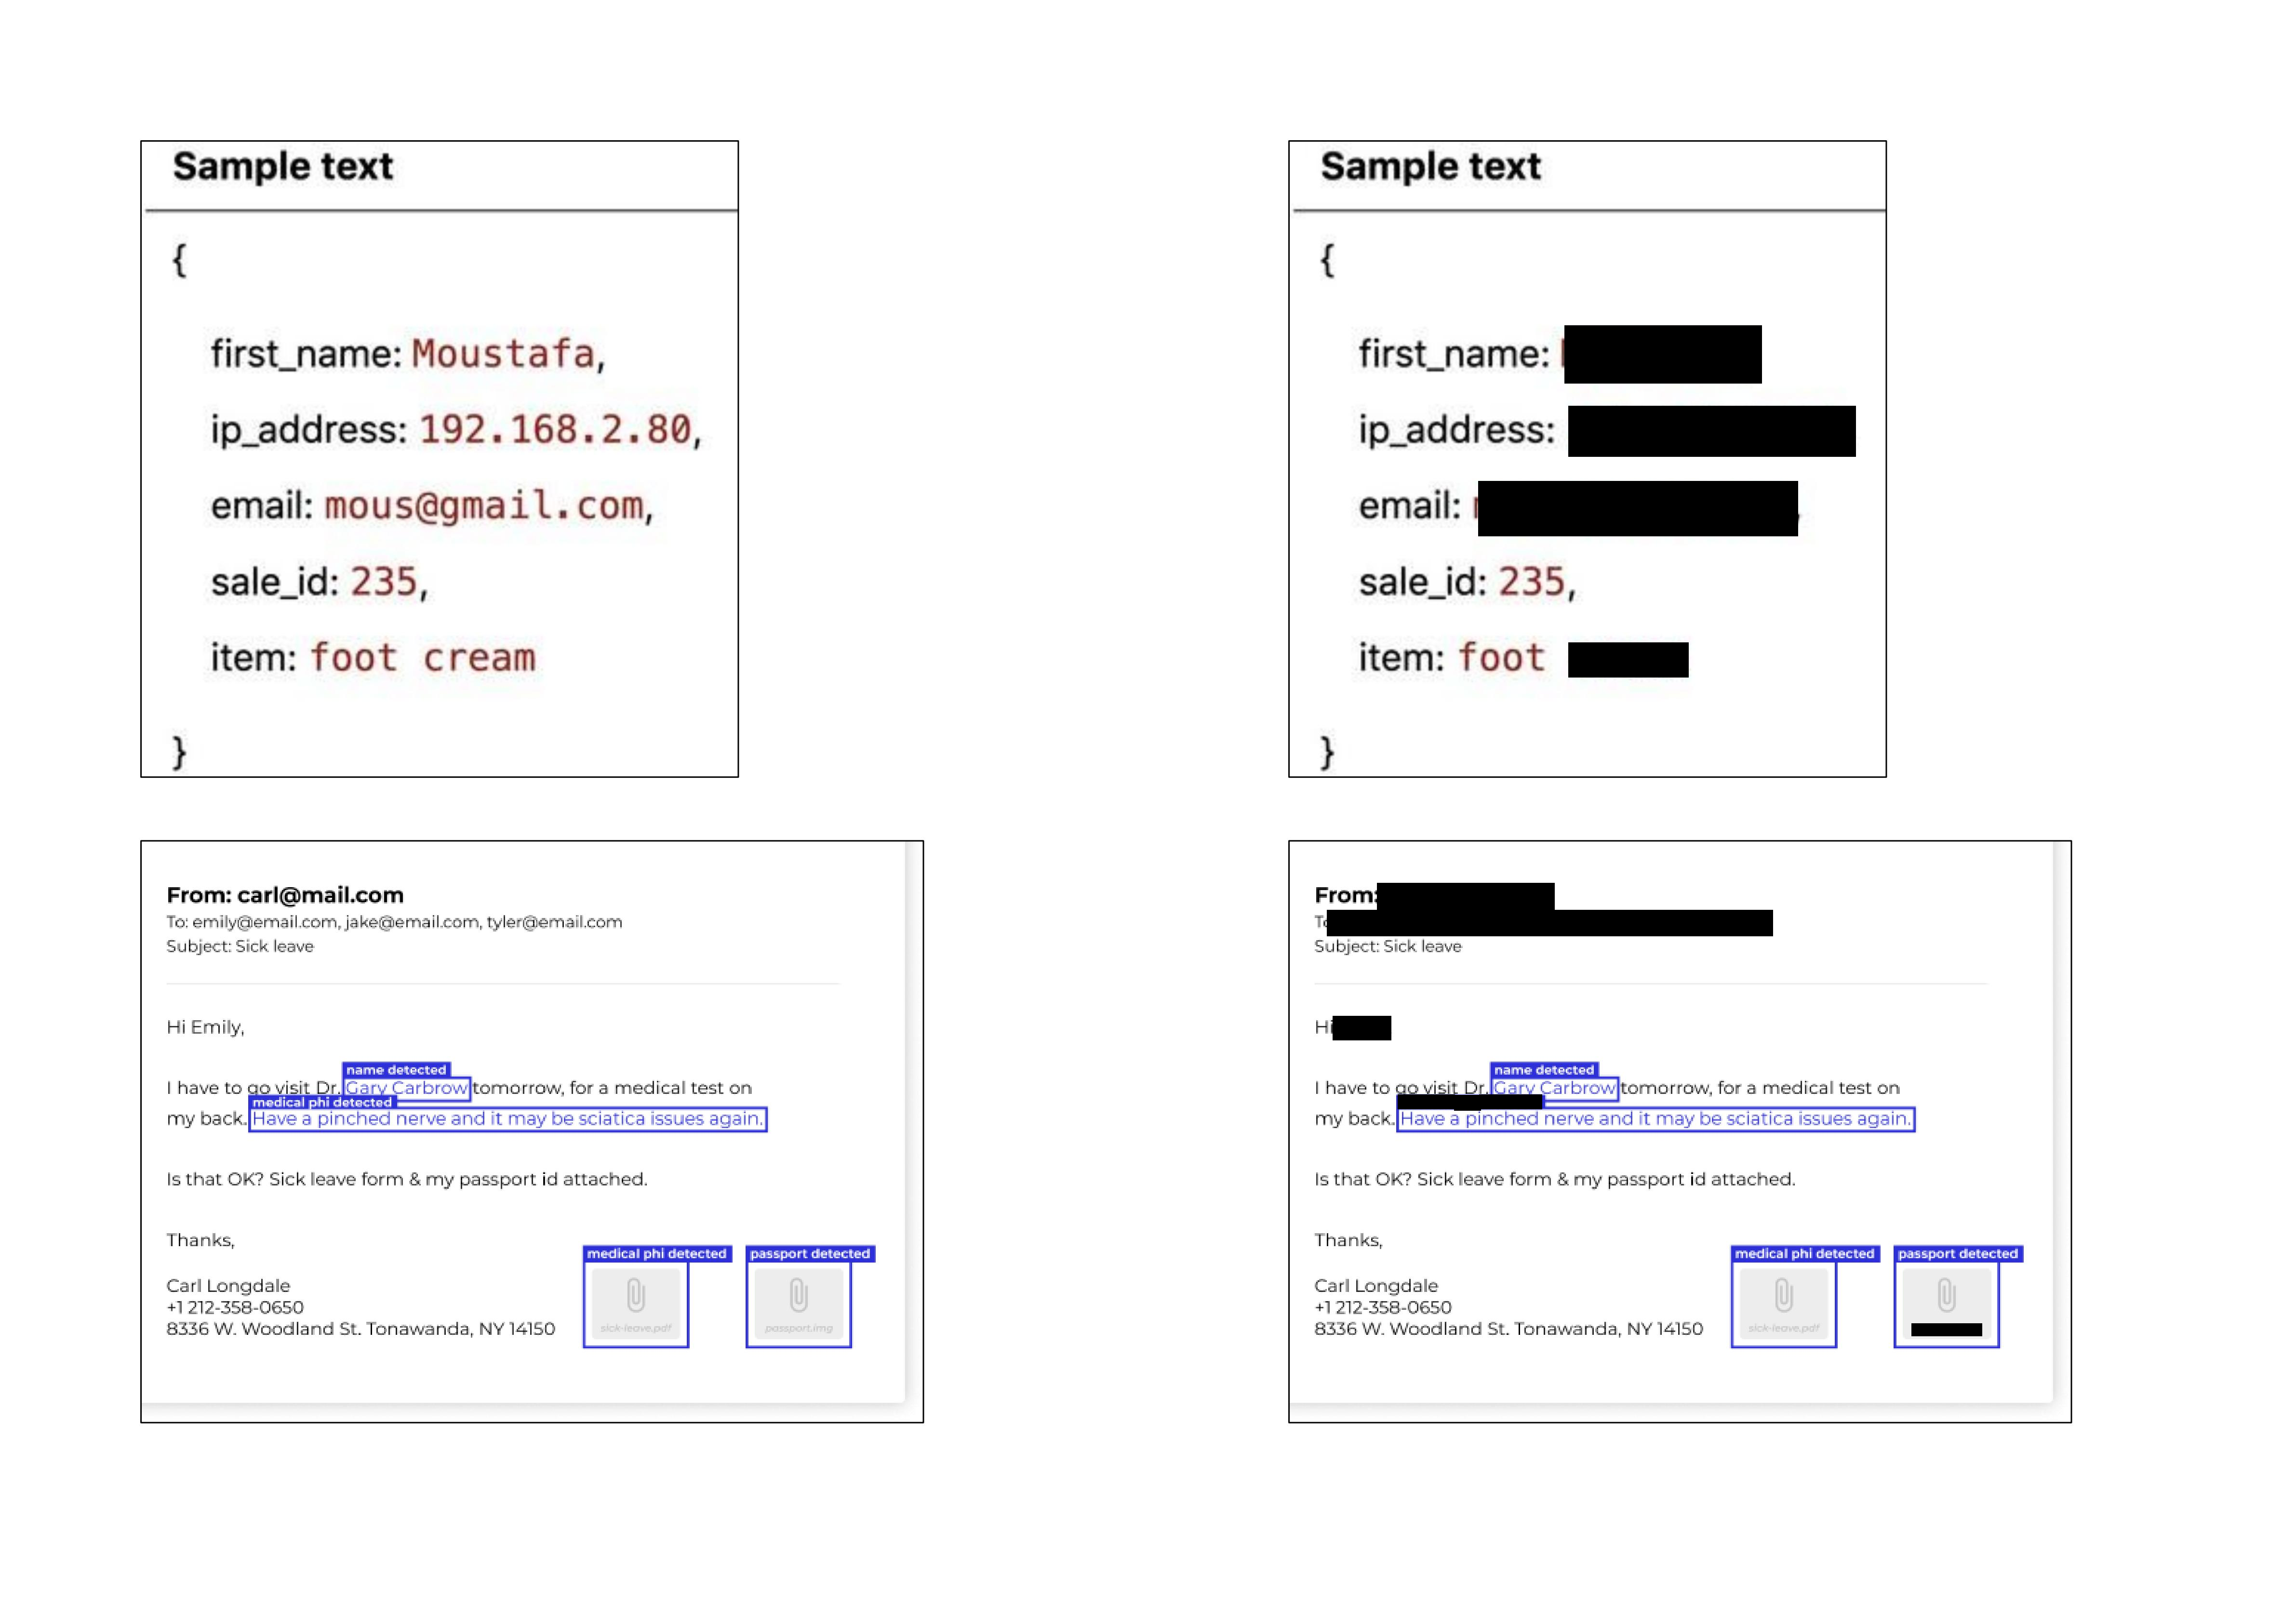

In [111]:
def process_pdf_pages(pdf_path, output_pdf_path, labels):
    pdf = pdfium.PdfDocument(pdf_path)
    processed_images = []

    for i in range(len(pdf)):
        page = pdf[i]
        image = page.render(scale=4).to_pil()
        image.save(f"output_{i:03d}.jpg")

        original_image = cv2.imread(f'output_{i:03d}.jpg')
        result = reader.readtext(f'output_{i:03d}.jpg', width_ths=0.5)

        processed_image = original_image.copy()
        draw_black_rectangles(processed_image, result, labels)

        processed_images.append(processed_image)

        # Display the modified image (optional)
        combined_image = np.hstack((original_image, processed_image))
        cv2_imshow(combined_image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    # Create a new PDF with the processed images
    pdf_writer = FPDF()

    for img in processed_images:
        img_path = "temp_page.jpg"
        cv2.imwrite(img_path, img)
        pdf_writer.add_page()
        pdf_writer.image(img_path, 0, 0, 210, 297)  # Adjust dimensions (210x297 mm) to match A4 size

    pdf_writer.output(output_pdf_path)

# Example usage
pdf_path = 'pii.pdf'
output_pdf_path = 'pii_redacted.pdf'
labels = ["ip address", "email", "passport number", "personally identifiable information", "social security number", "driver licence", "full address", "character"]

process_pdf_pages(pdf_path, output_pdf_path, labels)